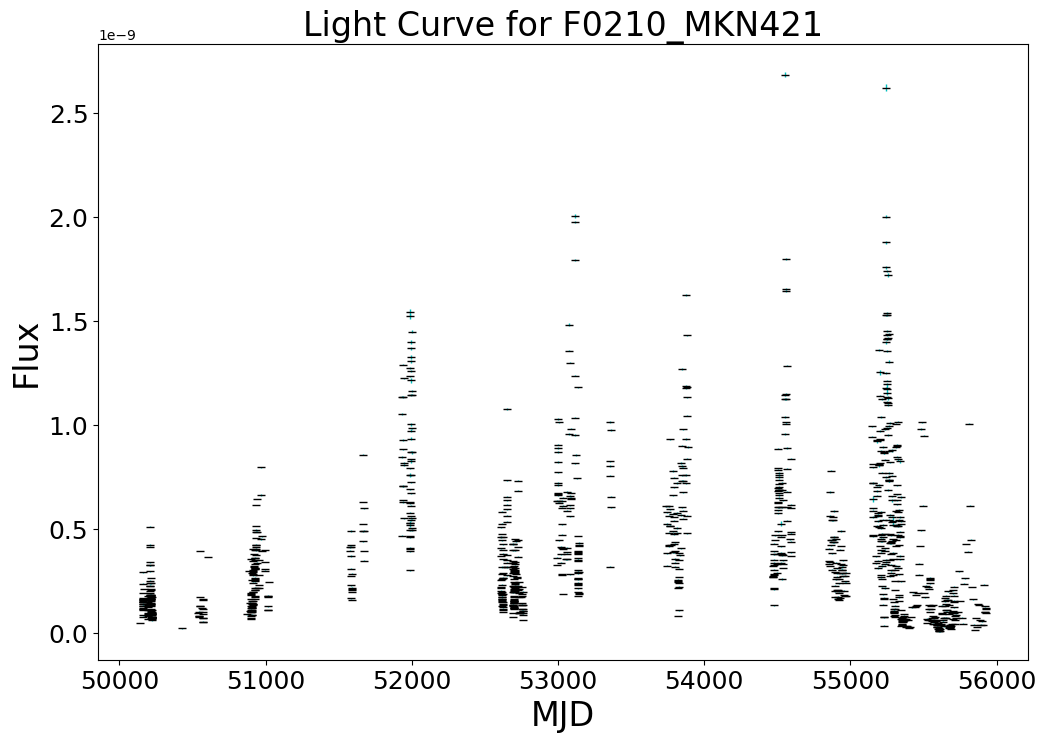

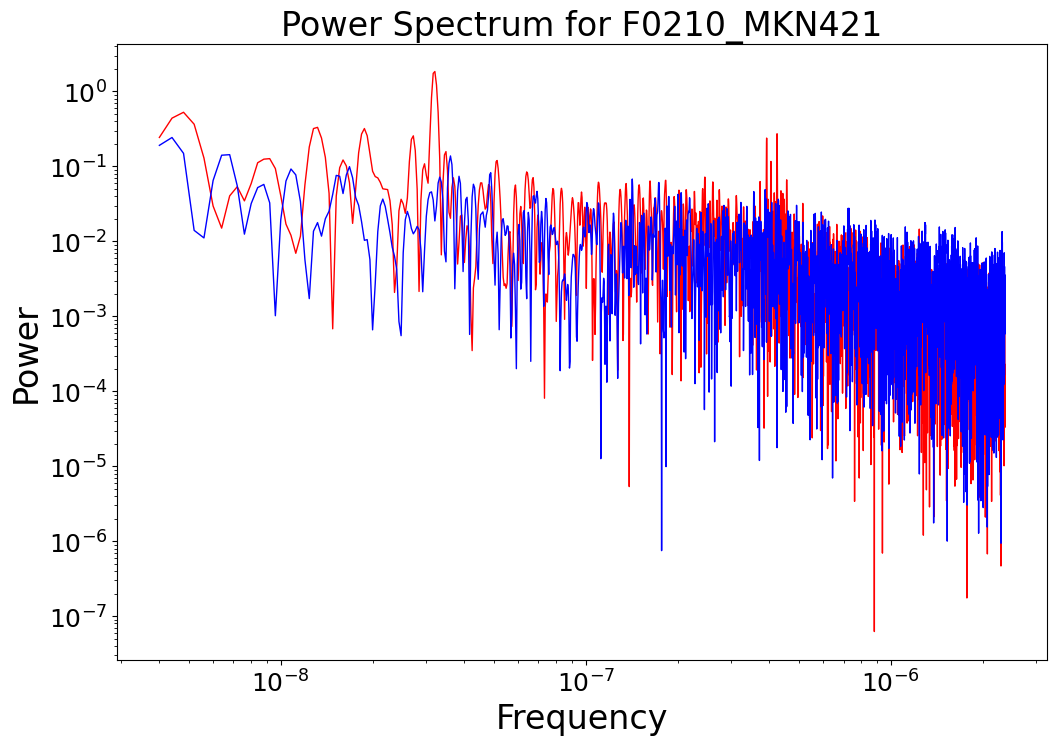


The count for frequency is: 5901

The count for power is:  5901

The percent error is:  0.5562298686938196
Minimum of the Periodogram:  4.002633428237005e-09
Maximum of the Periodogram:  0.24312287381842684
Index =  (array([1]),) [1]

Frequency at Maximum Power [4.40289677e-09]
Period = [2628.74073045] days

# of data points = 1182 Start MJD = 50143.268252 End MJD = 55926.497859
Data Span = 5783.2296069999975 days
Mean Spacing = 4.896892131244706 days
Mean power = 0.0050557574756675576   Power standard deviation = 0.009419717945684808
Number of independent frequencies [HB86] = 41158.86598

Nyquist-limited frequencies = 591.0
Z= 25.27327439266038   False Alarm Probability = 4.349298712291727e-07
AltFAP (Nyquist) = 6.245157724293904e-09



In [ ]:
# @title  { form-width: "25%" }
# @title  { form-width: "25px" }
# @title  { form-width: "20%" }
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.timeseries import LombScargle

# This establishes the parameters, setup as a form on the right
# file name (including .type) that contains the flux data
filename = "F0210_MKN421.txt"  # @param {type:"string"}
# number of lines to skip at the beginning of the file, genfromtxt automatically skips commented lines
skip_header = 0  # @param {type:"integer"}
# number of lines to skip at bottom
skip_footer = 0  # @param {type:"integer"}
# minimum_frequency, cuts off left of diagram; minif_factor is divided by Span
  #e.g., set to 2 to remove frequencies that would cover more than half the span
minif_factor = 2  # @param {type:"integer"}
# nyquist_factor, affects maximum_frequency based on the average nyquist factor
nyquist_factor = 2  # @param {type:"integer"}
# x,y limits on light curve (lc), periodogram (pd) power spectrum
  #give limits in the form "(lower, upper)"; leave blank to not limit the graphs
lc_xlim = None  # @param {type:"raw"}
lc_ylim = None  # @param {type:"raw"}
lsp_xlim = None  # @param {type:"raw"}
lsp_ylim = None  # @param {type:"raw"}


# load the text file with the flux data
AGN = np.genfromtxt(filename, skip_header = skip_header, skip_footer = skip_footer)

# set up the values
x = 86400*AGN[:,0]  #This is the first column of the data set (MJD midpoint of observation)
y = AGN[:,1]  #Second column of the data set (Flux)
dy = AGN[:,2]  #Third column of the data set (the uncertainty)


# get timespan and spacing of data
NumData = len(x)
Span = x[NumData - 1] - x[0]
MeanSpacing = Span / (NumData - 1)

# set up values for Thomas test
yy = 0 * x + 1  #Need to set the y values to one, in order to have the y axis be zero
dyy = 0 * x + 42
ffrequency, ppower = LombScargle(x, yy, dyy).autopower(minimum_frequency = minif_factor/Span, nyquist_factor = nyquist_factor)

# data for the periodogram
frequency, power = LombScargle(x, y, dy).autopower(minimum_frequency = minif_factor/Span, nyquist_factor = nyquist_factor)


# get the number of points in the periodogram
A = len(frequency)
B = len(power)

# get averages of the error and the flux to find the percent error
Error = np.mean(dy)
Mean = np.mean(y)


# finds the maximum and the minimum of the periodogram
array = frequency, power
np.max(array), np.min(array)
result = np.where(power == np.amax(power))
item = result[0]
fofmax = frequency[item]
period = 1/(fofmax*86400)

# calculate False Alarm Probability [Horne & Baliunas, 1986]
N_i = -6.392 + 1.193 * B + 0.00098 * B ** 2
Mu = np.mean(power)
Sigma = np.std(power)
Z = (np.max(power) - Mu)/Sigma
FAP = 1 - (1 - np.exp(-Z)) ** N_i
altFAP = 1 - (1 - np.exp(-Z)) ** (NumData/2)


# plot of light curve
plt.subplots(1,1,figsize=(12,8))
plt.title('Light Curve for ' + filename[:-4], fontsize=24)
plt.xlabel('MJD', fontsize=24)
plt.ylabel('Flux', fontsize=24)
if lc_xlim != None: plt.xlim(lc_xlim)
if lc_ylim != None: plt.ylim(lc_ylim)
plt.tick_params(labelsize=18)
#plt.plot(x/86400, y)
plt.errorbar(x/86400, y, yerr=dy, fmt='_k', ecolor='c', elinewidth=1);
#plt.savefig('NGC6251_LC.png')
plt.show()

# plot of power spectrum
plt.subplots(1,1,figsize=(12,8))
plt.xscale('log')  #This sets the x axis as a logarithmic function
plt.yscale('log')  #This sets the y axis as a logarithmic function
plt.title('Power Spectrum for ' + filename[:-4], fontsize=24)
plt.xlabel("Frequency", fontsize=24)
plt.ylabel('Power', fontsize=24)
if lsp_xlim != None: plt.xlim(lsp_xlim)
if lsp_ylim != None: plt.ylim(lsp_ylim)
plt.plot(ffrequency, ppower,'r', linewidth=1)
plt.plot(frequency, power, 'b', linewidth=1)
plt.tick_params(labelsize=18)
#plt.savefig('NGC6251_LSP.png')
plt.show()


# printing analysis results
print("\nThe count for frequency is:" , A)
print("\nThe count for power is: " , B)
print("\nThe percent error is: ", ((Error/Mean)*100),)
print("Minimum of the Periodogram: ", np.min(array))
print("Maximum of the Periodogram: ", np.max(array))
print("Index = ", result, item)
print("\nFrequency at Maximum Power", fofmax)
print("Period =", period, "days")
print("\n# of data points =", NumData, "Start MJD =", x[0]/86400, "End MJD =", x[NumData - 1]/86400)
print("Data Span =", Span/86400, "days",)
print("Mean Spacing =", MeanSpacing/86400, "days")
print("Mean power =", Mu, "  Power standard deviation =", Sigma)
print("Number of independent frequencies [HB86] =", N_i)
print("\nNyquist-limited frequencies =", NumData/2)
print("Z=", Z, "  False Alarm Probability =", FAP)
print("AltFAP (Nyquist) =", altFAP)
print("")